In [3]:
from calibration_functions import * 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
import pandas as pd

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

#### Find peaks in LFC exposure and fit each peak with super-gaussian and return peak locations


In [ ]:
results = fit_all_peaks_in_all_orders(filename="expres_tp/LFC_200907.1063.fits", correct_errors=True)

#### Interpolate even peaks and compute residuals for odd peaks, then flip

In [45]:
def compute_res(list, peak_fitting_results, omit_first=False, plot_orders=None):
    for r in peak_fitting_results:

        order, peak_fits, wavel_true, _ = r

        # Filter by chi2
        cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
        peak_fits_df = pd.DataFrame(peak_fits, columns=cols)
        chi2_mask = (peak_fits_df.chi2 < 100)
        peak_fits = peak_fits[chi2_mask]
        wavel_true = wavel_true[chi2_mask]

        # Skip if out of peaks... 
        if len(peak_fits) < 1:
            print("No peaks")
            continue 

        if omit_first:
            order, peak_fits, wavel_true = order, peak_fits[1:], wavel_true[1:]

        # Take every other element
        x_interp = peak_fits[:,2][::2]
        y_interp = wavel_true[::2][:, 0]

        f2 = interp1d(x_interp, y_interp, kind='cubic')

        # Residuals for all x and y
        x_remain = peak_fits[:, 2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
        y_remain = wavel_true[1::2][:, 0]
        x_remain = x_remain[1:-1]  # first and last data points don't work well — exclude them
        y_remain = y_remain[1:-1]
        
        y_predicted = f2(x_remain)

        # res = y_predicted - y # residuals
        c = 299792458 # m/s
        res = (y_predicted - y_remain)/y_remain * c
        list.append(res)

        if plot_orders is not None and (plot_orders == order).any():
            fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,4))
            ax1.plot(x_interp, y_interp, ".", label="Interpoalted data points")
            ax2.plot(x_remain, res, ".", label="Residuals")
            ax1.legend()
            ax2.legend()


def compute_interp_residuals(peak_fitting_results):
    residuals = []

    # Compute 1st half
    compute_res(residuals, peak_fitting_results)

    # Compute 2nd half by skipping first item
    compute_res(residuals, peak_fitting_results, omit_first=True)

    # Collapse to one list
    residuals = np.concatenate(residuals)

    return residuals

In [59]:
residuals = compute_interp_residuals(results)
np.savetxt("LFC_calib_results/residuals_interpolation.csv", residuals, delimiter=",")

In [56]:
def compute_rms(x):
    x = x - np.mean(x)
    return np.sqrt(np.sum(x ** 2) / len(x - 1))

10.011995510917203

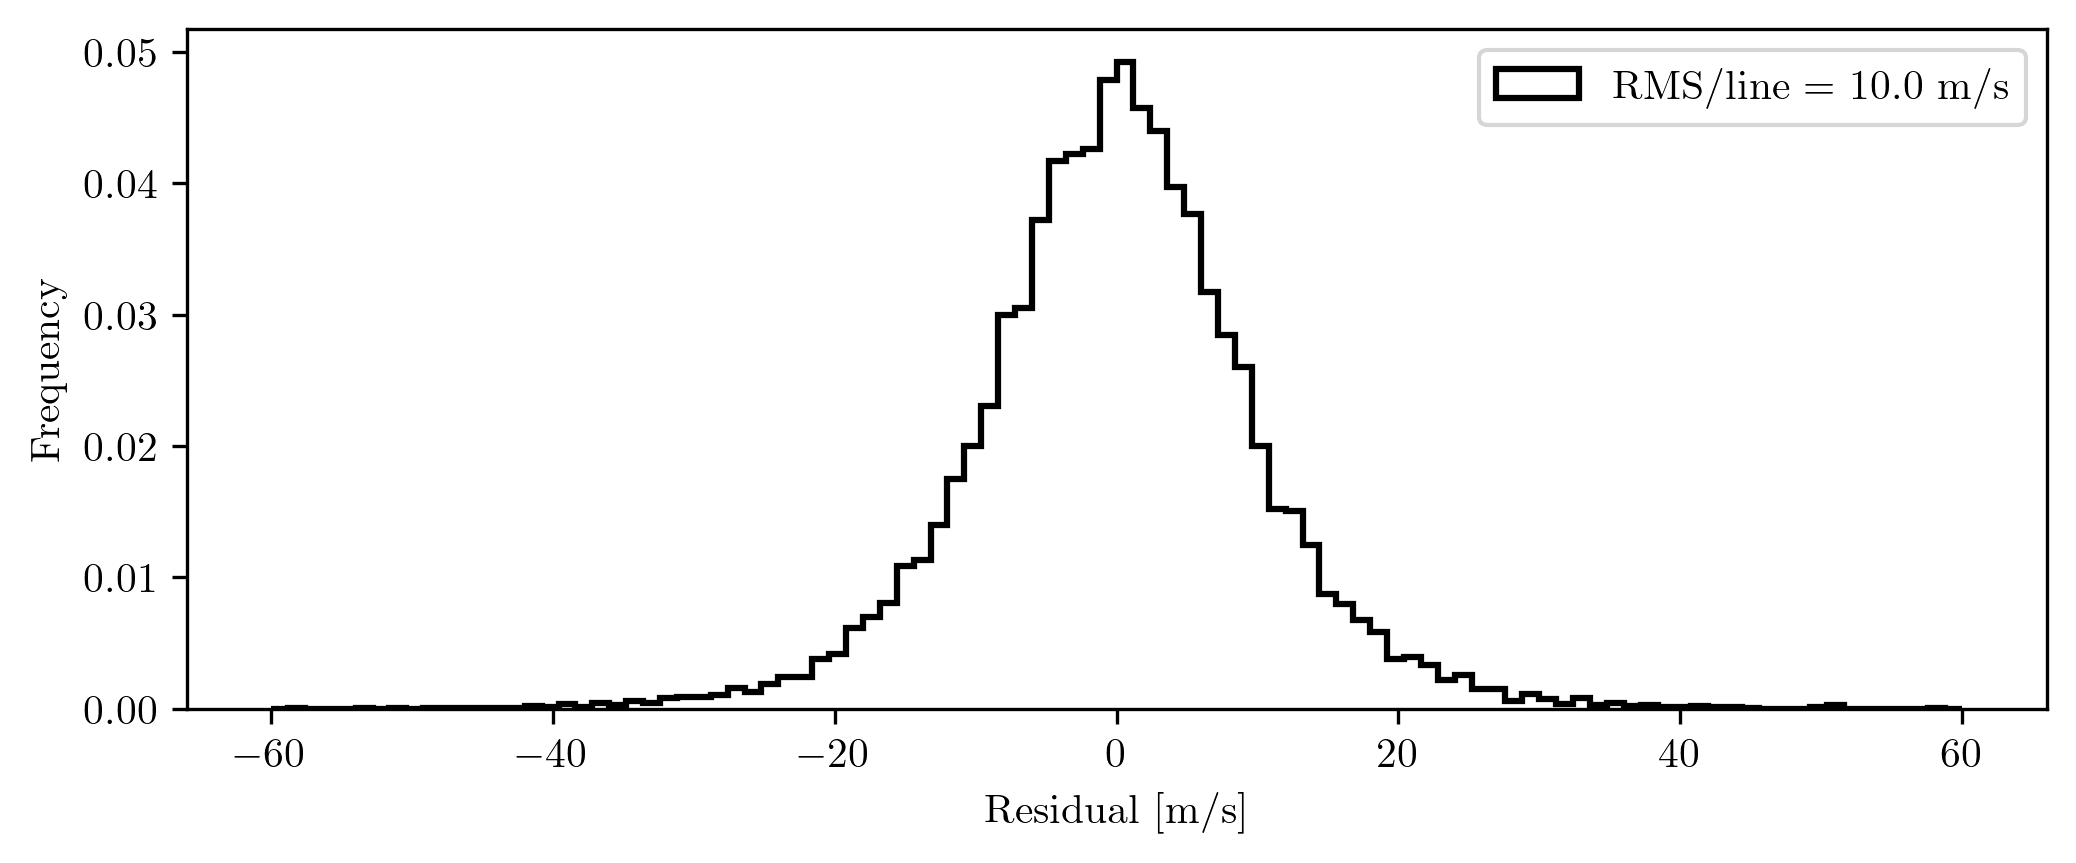

In [57]:
# Plot
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=100, range=(-60, 60), density=True, histtype="step", color="k", lw=1.5, label=f"RMS/line = {(compute_rms(residuals)):.3} m/s");
plt.xlabel("Residual [m/s]")
plt.ylabel("Frequency")
plt.legend()

x = residuals - np.mean(residuals)
standard_rms = np.sqrt(np.sum(x ** 2) / len(x - 1))
standard_rms

### Compare to 5 degree poly fit

Polyfit 5 : 16546 points, min = -14409859083.092703, max = 7762146272.774614
Interp: : 16366 points, min = -63.06716494824425, max = 85.96928425191474


(-100.0, 100.0)

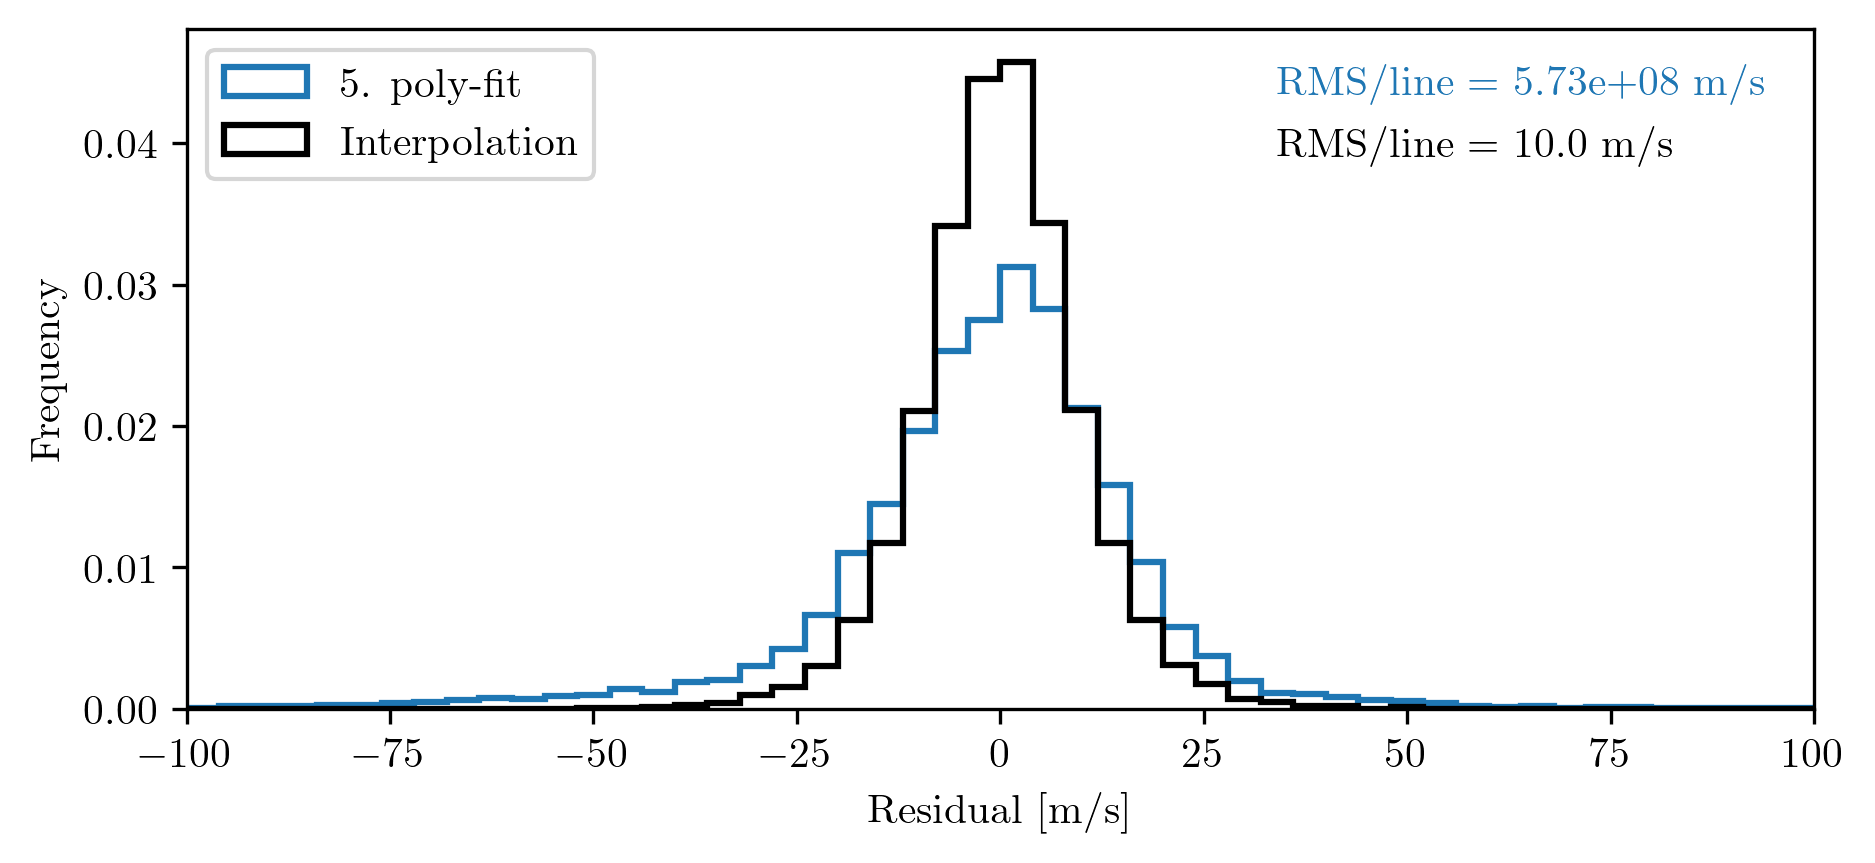

In [61]:
def print_res_info(title, res):
    res_min, res_max = np.nanmin(res), np.nanmax(res)
    res_len = len(res)
    print(f"{title} : {res_len} points, min = {res_min}, max = {res_max}")

res_fit5 = np.genfromtxt("LFC_calib_results/residuals_5th_poly.csv")
res_interp = np.genfromtxt("LFC_calib_results/residuals_interpolation.csv")

print_res_info("Polyfit 5", res_fit5)
print_res_info("Interp:", res_interp)

fig, ax = plt.subplots(figsize=(7,3))
mRange = (-200, 200)

ax.hist(res_fit5, bins=100, range=mRange, histtype="step",
            edgecolor="C0", lw=1.5, label=f"5. poly-fit", density=True);

ax.hist(res_interp, bins=100, range=mRange, histtype="step",
            edgecolor="k", lw=1.5, label=f"Interpolation", density=True);

ax.text(0.67, 0.95, f"RMS/line = {compute_rms(res_fit5):.3} m/s", color="C0", fontweight="500",
            size = 10, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

ax.text(0.67, 0.86, f"RMS/line = {compute_rms(res_interp):.3} m/s", color="k", fontweight="500",
            size = 10, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

ax.set_xlabel("Residual [m/s]")
ax.set_ylabel("Frequency")
ax.legend(loc="upper left")
ax.set_xlim(-100, 100)
# ax.tight_layout()

# plt.savefig("latex/figures/calib/hist_peak_residuals_poly_and_interp.pdf", bbox_inches="tight", dpi=300)